In [1]:
# CELL 1: Setup Environment
# ===========================
from google.colab import drive
import os, zipfile

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Path to your dataset ZIP in Drive
zip_path = '/content/drive/My Drive/DeepPCB_Project/PCB_DATASET.zip'
extract_path = '/content/dataset'

# Unzip dataset
if not os.path.exists(extract_path):
    os.makedirs(extract_path)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")

Dataset extracted successfully!


In [3]:
# Install Ultralytics YOLO and helper libraries
!pip install ultralytics opendatasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.7 MB/s eta 0:00:00


In [4]:
import torch
from ultralytics import YOLO
import os
import shutil
import xml.etree.ElementTree as ET
from glob import glob
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

# Check GPU
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Setup complete. Using torch 2.9.0+cu126 (Tesla T4)


In [28]:
# Define your classes strictly in order
CLASS_NAMES = [
    "Missing_hole", "Mouse_bite", "Open_circuit",
    "Short", "Spur", "Spurious_copper"
]

class_map_clean = {}
for i, name in enumerate(CLASS_NAMES):
    class_map_clean[name] = i
    class_map_clean[name.lower()] = i
    class_map_clean[name.lower().replace('_', ' ')] = i

# 2. Updated Converter Function
def convert_xml_to_yolo(xml_file, width, height):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    yolo_lines = []

    for obj in root.findall("object"):
        raw_name = obj.find("name").text.strip()

        # LOGIC FIX: Check against the smart map
        # Try exact match, then lowercase, then spaces
        name_key = raw_name
        if name_key not in class_map_clean:
            name_key = raw_name.lower()
        if name_key not in class_map_clean:
            name_key = raw_name.lower().replace('_', ' ')

        if name_key in class_map_clean:
            class_id = class_map_clean[name_key]

            bbox = obj.find("bndbox")
            xmin = float(bbox.find("xmin").text)
            ymin = float(bbox.find("ymin").text)
            xmax = float(bbox.find("xmax").text)
            ymax = float(bbox.find("ymax").text)

            # Normalize
            dw = 1.0 / width
            dh = 1.0 / height
            x_center = (xmin + xmax) / 2.0
            y_center = (ymin + ymax) / 2.0
            w = xmax - xmin
            h = ymax - ymin

            yolo_lines.append(f"{class_id} {x_center*dw:.6f} {y_center*dh:.6f} {w*dw:.6f} {h*dh:.6f}")

    return yolo_lines

print("Conversion functions ready.")

Conversion functions ready.


In [11]:
DATASET_DIR = os.path.join(extract_path, "PCB_DATASET")
IMAGES_DIR = os.path.join(DATASET_DIR, "images")
ANN_DIR = os.path.join(DATASET_DIR, "Annotations")

In [29]:
print(f"Checking dataset structure in: {DATASET_DIR}")

# 1. Check Main Directories
if os.path.exists(IMAGES_DIR):
    print(f"✅ IMAGES_DIR found: {IMAGES_DIR}")
else:
    print(f"❌ IMAGES_DIR NOT found: {IMAGES_DIR}")

if os.path.exists(ANN_DIR):
    print(f"✅ ANN_DIR found: {ANN_DIR}")
else:
    print(f"❌ ANN_DIR NOT found: {ANN_DIR}")

# 2. Check Subdirectories for each Class
print("\n--- Checking Subfolders for each Class ---")
for class_name in CLASS_NAMES:
    # Check Image Subfolder
    img_sub_path = os.path.join(IMAGES_DIR, class_name)
    if os.path.exists(img_sub_path):
        count = len(os.listdir(img_sub_path))
        print(f"  [Images]      {class_name:<20}: Found ✅ ({count} files)")
    else:
        print(f"  [Images]      {class_name:<20}: NOT FOUND ❌")

    # Check Annotation Subfolder
    ann_sub_path = os.path.join(ANN_DIR, class_name)
    if os.path.exists(ann_sub_path):
        count = len(os.listdir(ann_sub_path))
        print(f"  [Annotations] {class_name:<20}: Found ✅ ({count} files)")
    else:
        print(f"  [Annotations] {class_name:<20}: NOT FOUND ❌")

Checking dataset structure in: /content/dataset/PCB_DATASET
✅ IMAGES_DIR found: /content/dataset/PCB_DATASET/images
✅ ANN_DIR found: /content/dataset/PCB_DATASET/Annotations

--- Checking Subfolders for each Class ---
  [Images]      Missing_hole        : Found ✅ (115 files)
  [Annotations] Missing_hole        : Found ✅ (115 files)
  [Images]      Mouse_bite          : Found ✅ (115 files)
  [Annotations] Mouse_bite          : Found ✅ (115 files)
  [Images]      Open_circuit        : Found ✅ (116 files)
  [Annotations] Open_circuit        : Found ✅ (116 files)
  [Images]      Short               : Found ✅ (116 files)
  [Annotations] Short               : Found ✅ (116 files)
  [Images]      Spur                : Found ✅ (115 files)
  [Annotations] Spur                : Found ✅ (115 files)
  [Images]      Spurious_copper     : Found ✅ (116 files)
  [Annotations] Spurious_copper     : Found ✅ (116 files)


In [20]:
import glob

In [30]:
YOLO_DIR = '/content/yolo_dataset'

# Create the YOLO directory structure
if os.path.exists(YOLO_DIR):
    shutil.rmtree(YOLO_DIR) # Clean start

for folder in ['train/images', 'train/labels', 'val/images', 'val/labels', 'test/images', 'test/labels']:
    os.makedirs(os.path.join(YOLO_DIR, folder), exist_ok=True)

print(f"Scanning images in: {IMAGES_DIR}")

# Find all images recursively (since they are in class subfolders)
all_images = glob.glob(os.path.join(IMAGES_DIR, '**', '*.jpg'), recursive=True) + \
             glob.glob(os.path.join(IMAGES_DIR, '**', '*.JPG'), recursive=True)

print(f"Total Images Found: {len(all_images)}")

Scanning images in: /content/dataset/PCB_DATASET/images
Total Images Found: 693


In [31]:
# Split dataset: 80% Train, 10% Val, 10% Test
train_imgs, temp_imgs = train_test_split(all_images, test_size=0.2, random_state=42)
val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

print(f"Split: {len(train_imgs)} Train, {len(val_imgs)} Val, {len(test_imgs)} Test")

Split: 554 Train, 69 Val, 70 Test


In [32]:
import cv2

In [33]:
def process_files(image_list, split_name):
    print(f"Processing {split_name}...")
    for img_path in tqdm(image_list):
        # A. Copy Image
        dest_img = os.path.join(YOLO_DIR, split_name, 'images', os.path.basename(img_path))
        shutil.copy(img_path, dest_img)

        # B. Find Corresponding XML


        # 1. Get path relative to IMAGES_DIR (e.g., "Missing_hole/01.jpg")
        rel_path = os.path.relpath(img_path, IMAGES_DIR)

        # 2. Swap extension to .xml (e.g., "Missing_hole/01.xml")
        xml_rel_path = os.path.splitext(rel_path)[0] + '.xml'

        # 3. Join with ANN_DIR (e.g., ".../Annotations/Missing_hole/01.xml")
        xml_path = os.path.join(ANN_DIR, xml_rel_path)

        if not os.path.exists(xml_path):
            print(f"Warning: Label not found for {os.path.basename(img_path)}")
            continue

        # C. Convert Label
        img = cv2.imread(img_path)
        if img is None: continue
        h, w = img.shape[:2]

        yolo_labels = convert_xml_to_yolo(xml_path, w, h)

        # D. Save Label File
        label_name = os.path.basename(img_path).rsplit('.', 1)[0] + '.txt'
        dest_label = os.path.join(YOLO_DIR, split_name, 'labels', label_name)

        with open(dest_label, 'w') as f:
            f.write('\n'.join(yolo_labels))

# Run the processing
process_files(train_imgs, 'train')
process_files(val_imgs, 'val')
process_files(test_imgs, 'test')

Processing train...


  0%|          | 0/554 [00:00<?, ?it/s]

Processing val...


  0%|          | 0/69 [00:00<?, ?it/s]

Processing test...


  0%|          | 0/70 [00:00<?, ?it/s]

In [34]:
# 5. CREATE DATA.YAML

yaml_content = f"""
path: {YOLO_DIR}
train: train/images
val: val/images
test: test/images

nc: {len(CLASS_NAMES)}
names: {CLASS_NAMES}
"""

with open(os.path.join(YOLO_DIR, 'data.yaml'), 'w') as f:
    f.write(yaml_content)

print("\n✅ data.yaml created successfully!")
print("✅ Dataset is ready for YOLO training.")


✅ data.yaml created successfully!
✅ Dataset is ready for YOLO training.


In [38]:
# 1. Load the "Small" Model
model = YOLO('yolov8s.pt')

In [39]:
print("\n--- STARTING FULL TRAINING (25 Epochs) ---")
results = model.train(
    data=os.path.join(YOLO_DIR, 'data.yaml'),
    epochs=25,
    imgsz=1024,   # Keep high resolution for small defects
    batch=4,      # Keep low batch size for memory safety
    name='pcb_final_run',
    patience=5,   # Stop if no improvement for 5 epochs
    exist_ok=True # Overwrite existing run folder if needed
)


--- STARTING FULL TRAINING (25 Epochs) ---
Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=pcb_final_run, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=T

Running inference...

image 1/70 /content/yolo_dataset/test/images/01_missing_hole_01.jpg: 544x1024 3 Missing_holes, 44.7ms
image 2/70 /content/yolo_dataset/test/images/01_missing_hole_20.jpg: 544x1024 3 Missing_holes, 19.9ms
image 3/70 /content/yolo_dataset/test/images/01_mouse_bite_13.jpg: 544x1024 2 Mouse_bites, 19.9ms
image 4/70 /content/yolo_dataset/test/images/01_open_circuit_03.jpg: 544x1024 3 Open_circuits, 19.9ms
image 5/70 /content/yolo_dataset/test/images/01_open_circuit_14.jpg: 544x1024 3 Open_circuits, 19.9ms
image 6/70 /content/yolo_dataset/test/images/01_short_04.jpg: 544x1024 3 Shorts, 19.9ms
image 7/70 /content/yolo_dataset/test/images/01_spur_01.jpg: 544x1024 2 Spurs, 19.9ms
image 8/70 /content/yolo_dataset/test/images/01_spur_05.jpg: 544x1024 (no detections), 19.9ms
image 9/70 /content/yolo_dataset/test/images/01_spur_06.jpg: 544x1024 2 Spurs, 19.9ms
image 10/70 /content/yolo_dataset/test/images/01_spurious_copper_08.jpg: 544x1024 2 Spurious_coppers, 19.9ms
image 11/

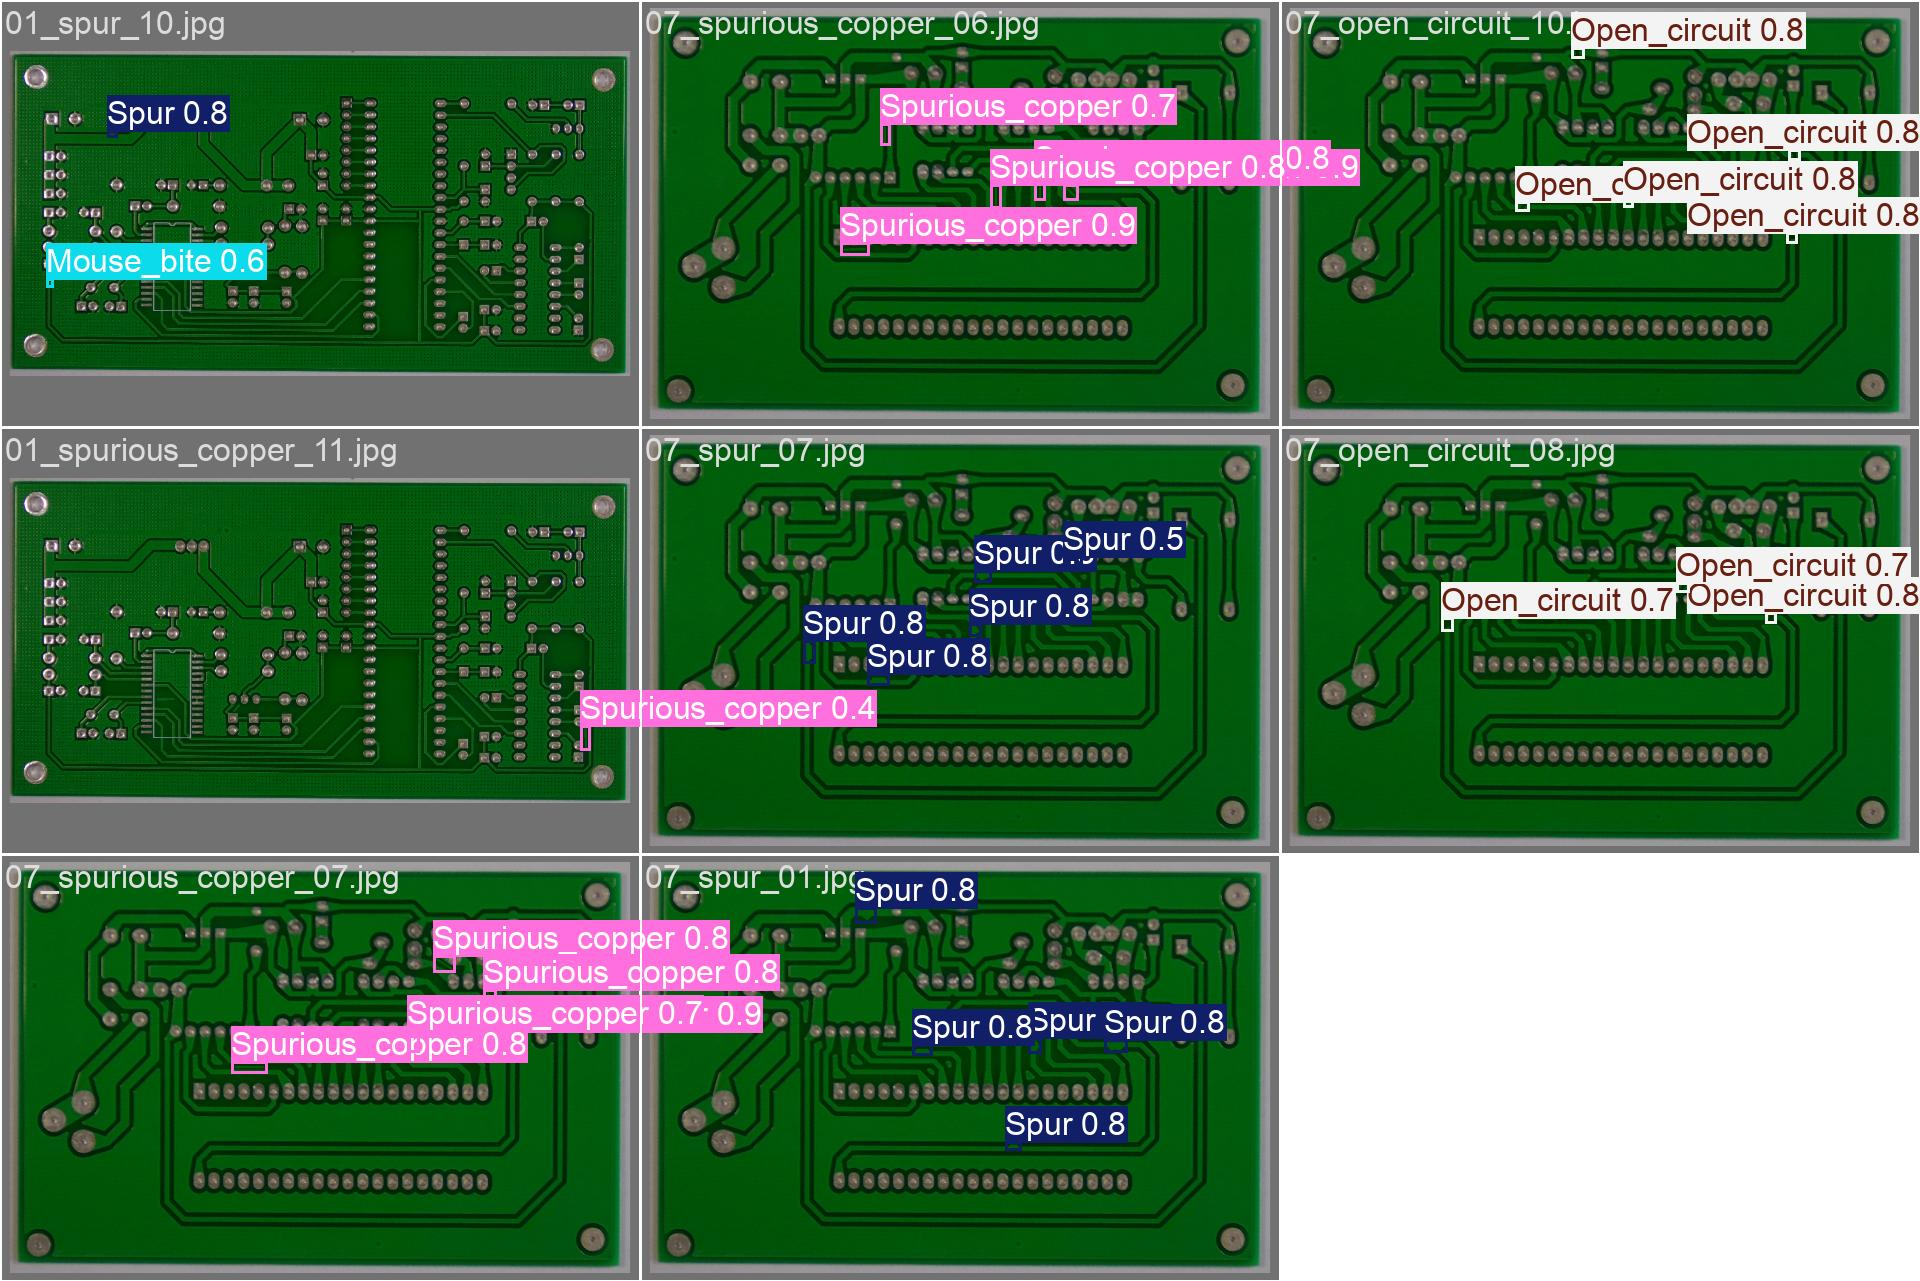

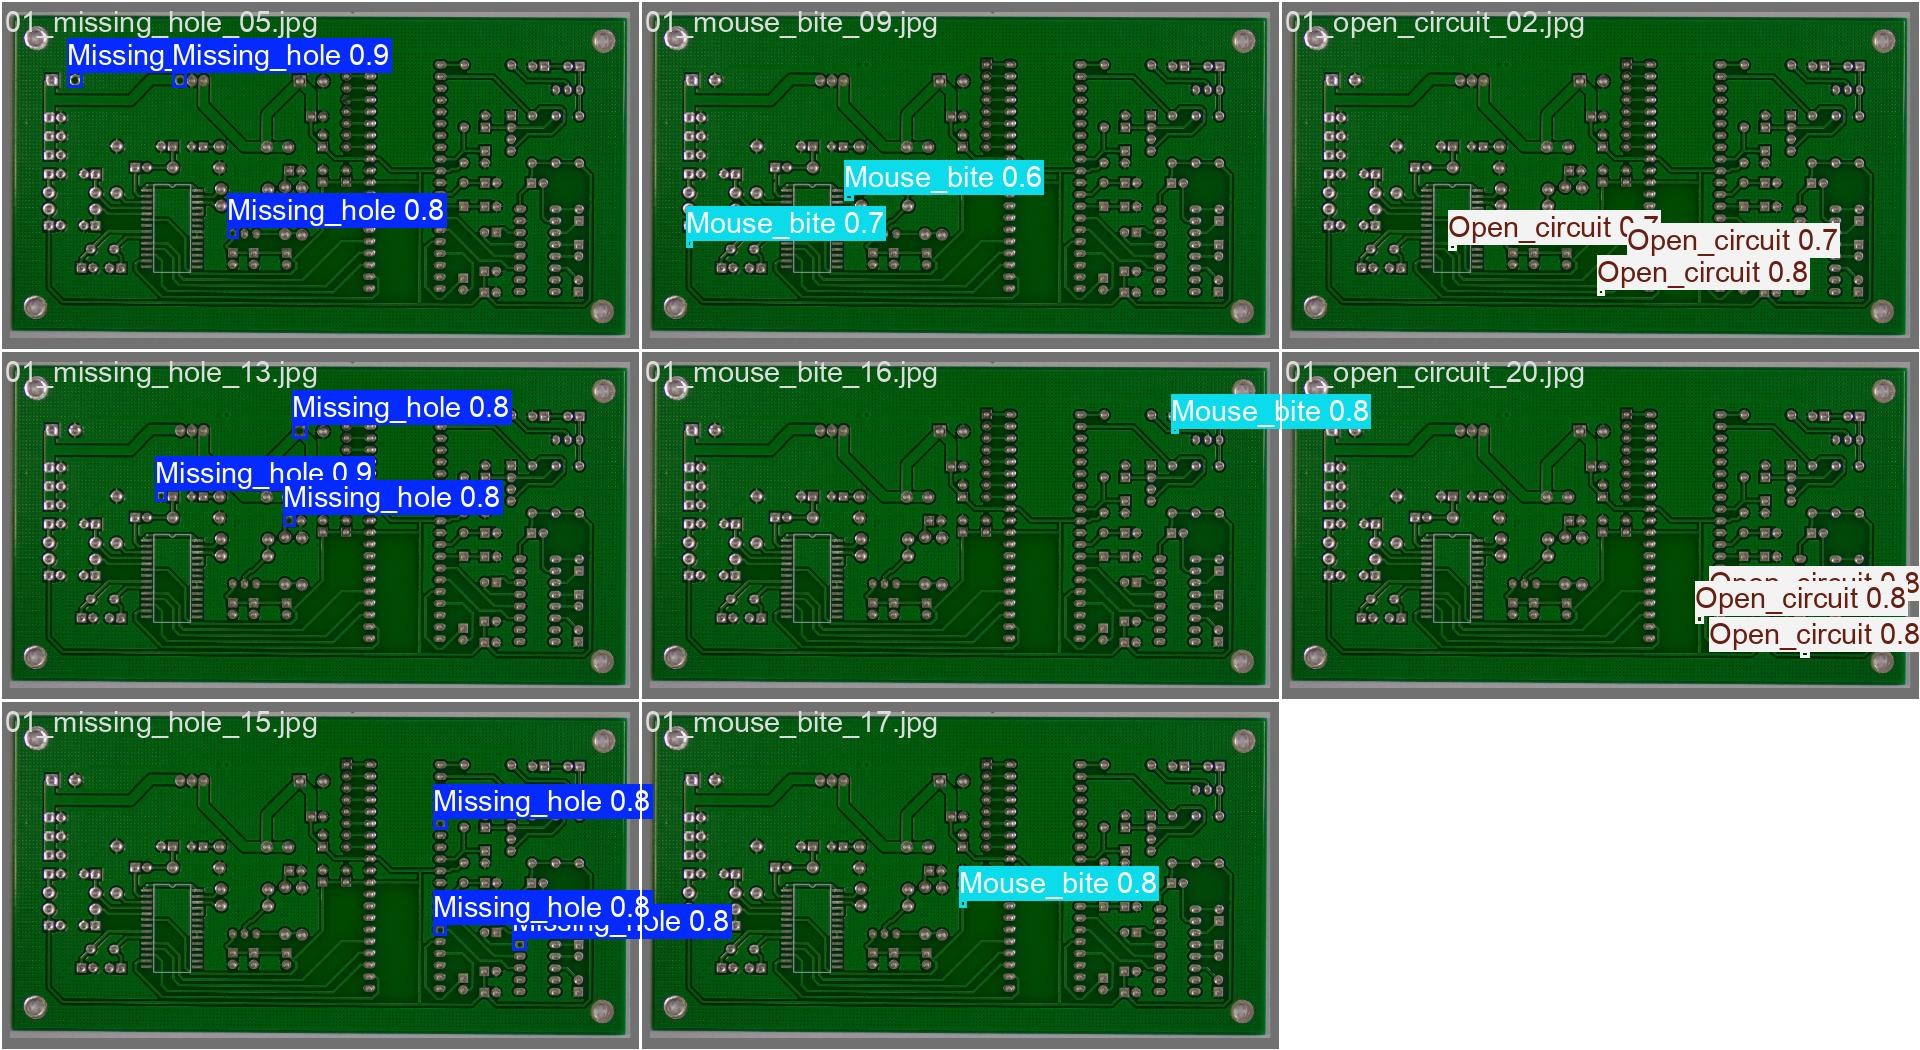

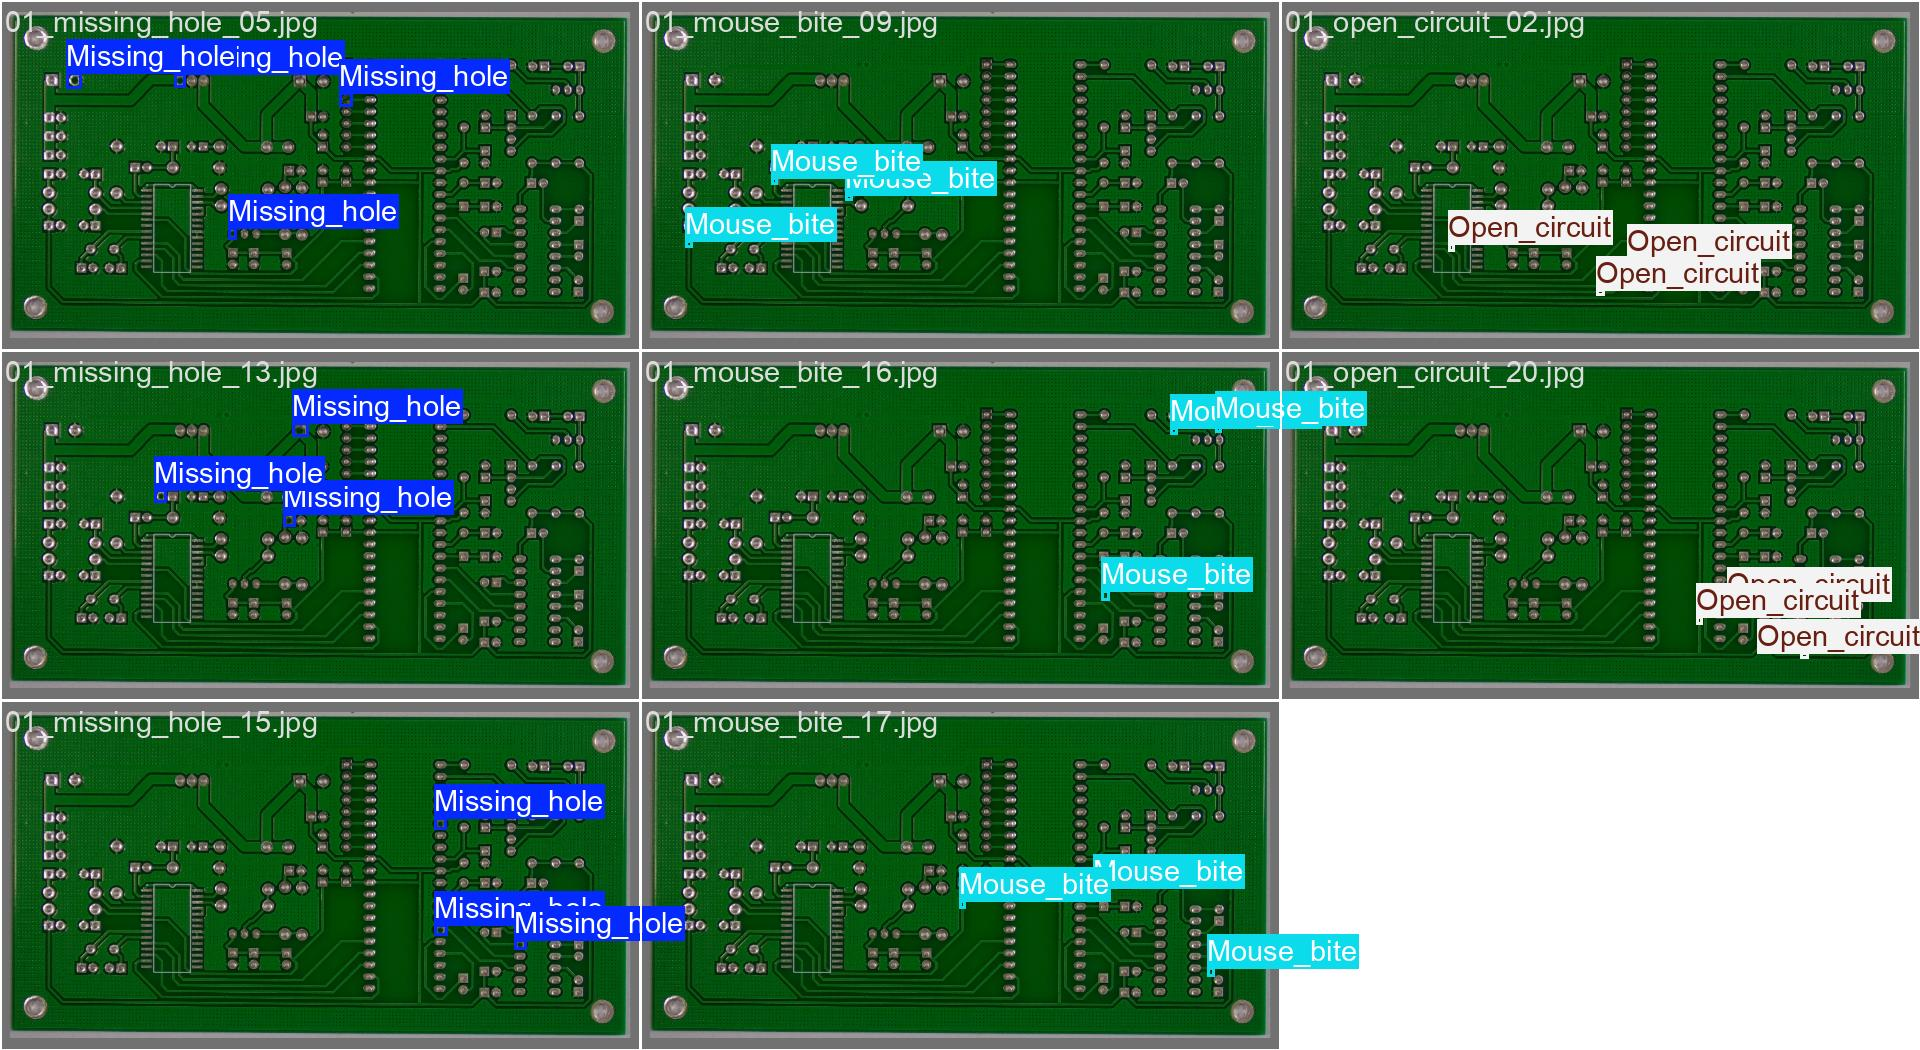

In [40]:
from IPython.display import Image, display
import random
import glob

# 1. Run Inference (High Res)
print("Running inference...")
results = model.predict(
    source=os.path.join(YOLO_DIR, "test/images"),
    conf=0.25,      # Sensitivity threshold. Lower to 0.15 if it still misses holes.
    save=True,
    imgsz=1024      # <--- CRITICAL: Must match training size!
)

# 2. Find the latest Output Folder
detect_runs = glob.glob('runs/detect/pcb_final_run*')

if detect_runs:
    # Get the newest folder created
    latest_run = max(detect_runs, key=os.path.getmtime)
    print(f"✅ Showing results from: {latest_run}")

    # 3. Display Random Samples
    result_images = glob.glob(os.path.join(latest_run, '*.jpg'))

    if result_images:
        print(f"Found {len(result_images)} detected images.")
        # Show 3 random images
        for img_path in random.sample(result_images, min(3, len(result_images))):
            display(Image(filename=img_path, width=800)) # Display slightly larger for you to see
    else:
        print("No images found. The model might not have detected anything confident enough.")
else:
    print("No run folders found.")

In [41]:
# 2. Find the trained model weights
# It's inside runs/detect/pcb_final_run/weights/
# We search automatically to be safe
run_folders = glob.glob('runs/detect/pcb_final_run*')

if run_folders:
    # Get the latest run folder
    latest_run = max(run_folders, key=os.path.getmtime)
    source_model_path = os.path.join(latest_run, 'weights', 'best.pt')

    # 3. Define Destination in Google Drive
    # Change 'DeepPCB_Project/Saved_Models' if you want a different name
    dest_dir = '/content/drive/My Drive/DeepPCB_Project/Saved_Models'
    os.makedirs(dest_dir, exist_ok=True)

    dest_model_path = os.path.join(dest_dir, 'pcb_yolo_model_v1.pt')

    # 4. Copy the file
    if os.path.exists(source_model_path):
        print(f"Copying model from: {source_model_path}")
        shutil.copy(source_model_path, dest_model_path)
        print(f"✅ SUCCESS! Model saved permanently to: {dest_model_path}")
    else:
        print(f"❌ Error: 'best.pt' not found in {latest_run}. Did training finish?")
else:
    print("❌ Error: No training run folders found.")

Copying model from: runs/detect/pcb_final_run/weights/best.pt
✅ SUCCESS! Model saved permanently to: /content/drive/My Drive/DeepPCB_Project/Saved_Models/pcb_yolo_model_v1.pt


In [42]:
# to use model in future
'''
from ultralytics import YOLO
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive')

# 2. Load the trained model directly from Drive
model_path = '/content/drive/My Drive/DeepPCB_Project/Saved_Models/pcb_yolo_model_v1.pt'

print(f"Loading model from: {model_path}...")
model = YOLO(model_path)
print("✅ Model loaded! You can skip training and go straight to prediction.")

# 3. Use it immediately
# results = model.predict(source='...', save=True)'''

'\nfrom ultralytics import YOLO\nfrom google.colab import drive\n\n# 1. Mount Drive\ndrive.mount(\'/content/drive\')\n\n# 2. Load the trained model directly from Drive\nmodel_path = \'/content/drive/My Drive/DeepPCB_Project/Saved_Models/pcb_yolo_model_v1.pt\'\n\nprint(f"Loading model from: {model_path}...")\nmodel = YOLO(model_path)\nprint("✅ Model loaded! You can skip training and go straight to prediction.")\n\n# 3. Use it immediately\n# results = model.predict(source=\'...\', save=True)'